In [1]:
!pip install imutils


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from matplotlib import pyplot as plt
import numpy as np

In [21]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

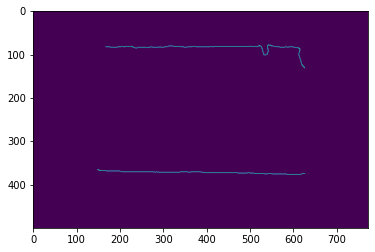

In [22]:
# load the example image
image = cv2.imread("lab_img_num.jpg")
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)
plt.imshow(edged)

In [5]:
# # find contours in the edge map, then sort them by their
# # size in descending order
# cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
# 	cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
# displayCnt = None
# # loop over the contours
# for c in cnts:
# 	# approximate the contour
# 	peri = cv2.arcLength(c, True)
# 	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
# 	# if the contour has four vertices, then we have found
# 	# the thermostat display
# 	if len(approx) == 4:
# 		displayCnt = approx
# 		break

In [6]:
# # extract the thermostat display, apply a perspective transform
# # to it
# warped = four_point_transform(gray, displayCnt.reshape(4, 2))
# output = four_point_transform(image, displayCnt.reshape(4, 2))

# displayCnt

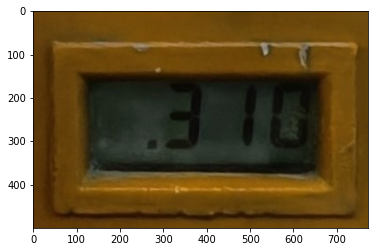

In [11]:
plt.imshow(image)

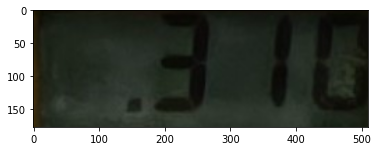

In [30]:

displayCnt=np.array([[120, 162],
       [120, 340],
       [630, 340],
       [630, 162]])
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))
plt.imshow(output)

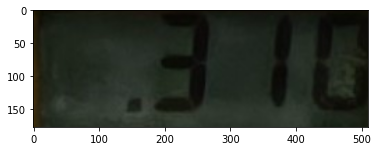

In [31]:
plt.imshow(output)

In [32]:
# threshold the warped image, then apply a series of morphological
# operations to cleanup the thresholded image
thresh = cv2.threshold(warped, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

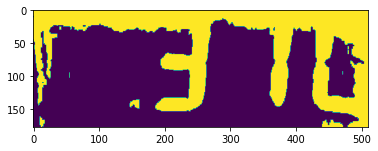

In [33]:
plt.imshow(thresh)

In [10]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# if the contour is sufficiently large, it must be a digit
	if w >= 15 and (h >= 30 and h <= 40):
		print("found a bounding box")
		digitCnts.append(c)

found a bounding box
found a bounding box
found a bounding box


In [11]:
# sort the contours from left-to-right, then initialize the
# actual digits themselves
digitCnts = contours.sort_contours(digitCnts,
	method="left-to-right")[0]
digits = []

In [12]:
len(digitCnts)

3

In [13]:
# loop over each of the digits
for c in digitCnts:
	# extract the digit ROI
	(x, y, w, h) = cv2.boundingRect(c)
	roi = thresh[y:y + h, x:x + w]
	# compute the width and height of each of the 7 segments
	# we are going to examine
	(roiH, roiW) = roi.shape
	(dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
	dHC = int(roiH * 0.05)
	# define the set of 7 segments
	segments = [
		((0, 0), (w, dH)),	# top
		((0, 0), (dW, h // 2)),	# top-left
		((w - dW, 0), (w, h // 2)),	# top-right
		((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
		((0, h // 2), (dW, h)),	# bottom-left
		((w - dW, h // 2), (w, h)),	# bottom-right
		((0, h - dH), (w, h))	# bottom
	]
	on = [0] * len(segments)
	# loop over the segments
	for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
		# extract the segment ROI, count the total number of
		# thresholded pixels in the segment, and then compute
		# the area of the segment
		segROI = roi[yA:yB, xA:xB]
		total = cv2.countNonZero(segROI)
		area = (xB - xA) * (yB - yA)
		# if the total number of non-zero pixels is greater than
		# 50% of the area, mark the segment as "on"
		if total / float(area) > 0.5:
			on[i]= 1
	# lookup the digit and draw it on the image
	digit = DIGITS_LOOKUP[tuple(on)]
	digits.append(digit)
	cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
	cv2.putText(output, str(digit), (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
	print(digit)

3
4
5


In [14]:
segments

[((0, 0), (19, 5)),
 ((0, 0), (4, 17)),
 ((15, 0), (19, 17)),
 ((0, 16), (19, 18)),
 ((0, 17), (4, 34)),
 ((15, 17), (19, 34)),
 ((0, 29), (19, 34))]

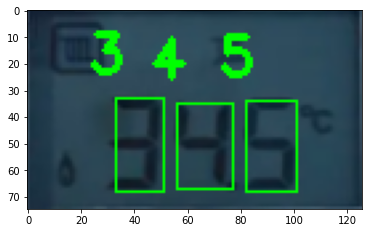

In [15]:
plt.imshow(output)

In [16]:
# display the digits
print(digits)
print(u"{}{}.{} \u00b0C".format(*digits))
# cv2.imshow("Input", image)
# cv2.imshow("Output", output)
# cv2.waitKey(0)

[3, 4, 5]
34.5 °C
